# Assignment Introduction to Python course (BIO102.1)
*by Georgios Kousis Tsampazis*


## Overview

This notebook documents a complete workflow for analyzing codon usage bias and its relationship to gene expression in **human breast tissue**. The analysis utilizes publicly available genomic and transcriptomic data to:

- Download and preprocessed gene expression and genomic sequence data
- Run `tRNAscan-SE` to determine optimal codons per amino acid
- Extract the longest CDS (coding DNA sequence) per gene from a FASTA file
- Compute codon usage ratios for each gene
- Correlate codon usage bias with gene expression levels (RPKM)
- Visualize the relationship

The goal is to assess whether highly expressed genes preferentially use optimal codons, a key concept in understanding translational efficiency and selection in gene regulation.

### Recommended Environment

To ensure compatibility and reproducibility, it's strongly recommended to run this workflow in a **Conda environment**. This allows for easy installation of required tools (such as `tRNAscan-SE`) and Python libraries.

Example Conda environment setup:

```bash
conda create -n codon_env python=3.13 bioconda::trnascan-se tqdm pandas matplotlib seaborn biopython plotly scipy -y
conda activate codon_env


### Downloading Required Files for Data Assignment

**Objective:**  
Ensure all necessary files for the analysis are present in the `data_assignment` directory. If a file is missing, download it from the specified URL.

**Files to Download:**

- `ERX011225_gene.txt.gz`  
- `GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz`  
- `GCF_000001405.40_GRCh38.p14_genomic.fna.gz`  
- `GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out`

**Dependencies:**

- `tqdm`
- `requests`

In [46]:
pip install tqdm requests

Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
import requests
from tqdm import tqdm

# Create the data directory if it doesn't exist.
data_dir = "./data_assignment"
os.makedirs(data_dir, exist_ok=True)
files_to_download = {
    "ERX011225_gene.txt.gz": "https://ngdc.cncb.ac.cn/mtd/download/human/ERX011225_gene.txt.gz",
    "GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz": "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz",
    "GCF_000001405.40_GRCh38.p14_genomic.fna.gz": "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_genomic.fna.gz",
    "GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out": "https://raw.githubusercontent.com/geokousis/Intro-Python/main/trnascan_grch38.txt"
}

def download_file(url, file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an error for bad status codes.
    
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte blocks

    with open(file_path, 'wb') as file, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=os.path.basename(file_path)
        ) as progress_bar:
        for data in response.iter_content(block_size):
            file.write(data)
            progress_bar.update(len(data))

for filename, url in files_to_download.items():
    file_path = os.path.join(data_dir, filename)
    if not os.path.exists(file_path):
        print(f"Downloading {filename} ...")
        try:
            download_file(url, file_path)
            print(f"{filename} downloaded successfully.")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
    else:
        print(f"{filename} already exists. Skipping download.")
print("Files are ready.")


ERX011225_gene.txt.gz already exists. Skipping download.
GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz already exists. Skipping download.
GCF_000001405.40_GRCh38.p14_genomic.fna.gz already exists. Skipping download.
GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out already exists. Skipping download.
Files are ready.


### Running tRNAscan-SE on GRCh38 Human Genome

**Objective:**  
Check if the output file from `tRNAscan-SE` exists. If not, set up the environment and run the tool on the GRCh38 reference genome.

**Script Overview:**

- Checks for the existence of the output file: `GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out`
- If not found:
  - Creates a Conda environment with `tRNAscan-SE`
  - Unzips the input FASTA file (as `tRNAscan-SE` requires uncompressed input)
  - Executes `tRNAscan-SE` using the specified number of threads

**Dependencies:**

- **Conda:**
  - `bioconda::trnascan-se`

**Side notes:**
- A different conda envrioment is created to not deal with package conflicts and extensive solving times (safe approach for not actively-developed/famous tools)

In [44]:
import os
from pathlib import Path

# Path to output file
file_path = Path("./data_assignment/GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out")
threads =10 # number of threads for tRNAscan-SE

if file_path.exists():
    print(file_path)
    print("File exists:", file_path)
else:
    print(file_path)
    print("File does not exist. Setting up environment and running tRNAscan-SE...")
    

    # Create conda environment and install tRNAscan-SE
    !conda create -y -n trnascan_env bioconda::trnascan-se

    # Unzip the genomic FASTA file (input of tRNAscan must be unziped)
    !gunzip ./data_assigmnet/GCF_000001405.40_GRCh38.p14_genomic.fna.gz

    # Run tRNAscan-SE 
    !conda run -n trnascan_env tRNAscan-SE ./data_assigmnet/GCF_000001405.40_GRCh38.p14_genomic.fna -o ./data_assigmnet/GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out --thread threads


data_assignment/GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out
File exists: data_assignment/GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out


## Expression Parsing


### Parsing Expression Data: Retaining Only the Highest RPKM Isoform

**Dataset:** *Human Breast Tissue*  
**Source File:** `ERX011225_gene.txt.gz`

**Objective:**  
Extract expression data, keeping only the isoform with the highest RPKM value for each gene.

**Output:**  
A DataFrame containing:
- Gene Name  
- Corresponding RPKM Value (highest per gene)


In [45]:
import pandas as pd

def keep_rpkm_gene(file):
    """
    Keep the row with the highest RPKM for each Gene_Symbol in the given file.
    Input:
        file is a gzipped tab-separated typically derived from ngdc
    Returns:
        df_result: DataFrame with Gene_Symbol and RPKM
    """
    df = pd.read_csv(file, compression='gzip', header=0, sep='\t')
    
    # Drop the last column
    df = df.iloc[:, :-1]
    
    # Keep the row with the highest RPKM for each Gene_Symbol
    df_highest_rpkm = df.loc[df.groupby('Gene_Symbol')['RPKM'].idxmax()]
    
    # Keep only Gene_Symbol and RPKM columns
    df_result = df_highest_rpkm[['Gene_Symbol', 'RPKM']]
    return df_result
rpkm=keep_rpkm_gene("./data_assignment/ERX011225_gene.txt.gz")
print(rpkm)

      Gene_Symbol        RPKM
6095         A1BG    0.218907
112      A1BG-AS1    0.082974
14997        A1CF    0.010768
5336          A2M  210.836000
82        A2M-AS1    1.087030
...           ...         ...
13642      ZYG11A    0.091902
7656       ZYG11B   13.849700
4964          ZYX   60.034900
10191       ZZEF1    3.736200
2771         ZZZ3    7.811970

[18303 rows x 2 columns]


### Finding Optimal Codon per Amino Acid

**Objective:**  
Analyze codon usage from tRNAs predicted by `tRNAscan-SE`, determine the most frequent (optimal) codon for each amino acid, and visualize the codon distribution.

**Output:**  
- Dictionary of optimal codons per amino acid  
- Stacked bar plot showing codon frequency per amino acid

**Utilizing:**
- `GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out` (tRNAscan-SE output)


In [50]:
pip install biopython pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from Bio.Seq import Seq
from Bio.Data.IUPACData import protein_letters_3to1

codon2aa = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                 
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W'
}

# Load the tRNAscan.
df = pd.read_csv('./data_assignment/GCF_000001405.40_GRCh38.p14_genomic.tRNAscan.out', sep='\t', header=1, skiprows=[2])
df_notpseudo = df[~df.iloc[:, -1].str.contains("pseudo", na=False)].copy()
df_notpseudo['Codon'] = df_notpseudo['Codon'].apply(lambda x: str(Seq(x).reverse_complement()) if pd.notna(x) else x)

# If the annotation contains "iMet" (initiator methionine), assign 'M'
annotation_col = df_notpseudo.columns[-1] 

def map_aa(row):
    if "iMet" in str(row[annotation_col]):
        return 'M'
    else:
        return codon2aa.get(row['Codon'], None)

df_notpseudo['aa'] = df_notpseudo.apply(map_aa, axis=1)

optimal_dict = {}
for aa, group in df_notpseudo.groupby('aa'):
    codon_opt = group['Codon'].value_counts().idxmax() # Get the most frequent codon for each amino acid
    optimal_dict[aa] = codon_opt
print("\nOptimal codon per amino acid:")
print(optimal_dict)

# Plotting
codon_usage = df_notpseudo.groupby(['aa', 'Codon']).size().unstack(fill_value=0)
import plotly.graph_objects as go
fig = go.Figure()

for codon in codon_usage.columns:
    fig.add_trace(go.Bar(
        x=codon_usage.index,  
        y=codon_usage[codon], 
        name=codon             
    ))

fig.update_layout(
    barmode='stack',
    title='Codon Usage per Amino Acid',
    xaxis_title='Amino Acid',
    yaxis_title='Count',
    width=1000,   
    height=700
)

fig.show()


Optimal codon per amino acid:
{'*': 'TGA', 'A': 'GCT', 'C': 'TGC', 'D': 'GAC', 'E': 'GAG', 'F': 'TTC', 'G': 'GGG', 'H': 'CAC', 'I': 'ATT', 'K': 'AAA', 'L': 'CTT', 'M': 'ATG', 'N': 'AAC', 'P': 'CCT', 'Q': 'CAG', 'R': 'CGG', 'S': 'TCT', 'T': 'ACT', 'V': 'GTG', 'W': 'TGG', 'Y': 'TAC'}


### Parsing CDS FASTA to Extract Longest Transcript per Gene

**Objective:**  
Process a gzipped FASTA file containing coding sequences (CDS) from the human genome, extract the gene identifier from the header, and retain only the longest sequence per gene.

**Output:**
- Total number of CDS records
- Number of sequences starting with `ATG`
- Dictionary mapping gene names to their longest CDS sequence

**Utilizing:**
- `GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz`


In [47]:
import gzip
import re

def process_fasta(filename):
    """
    Process a gzipped FASTA file and extracts records,
    keeping only the longest sequence for each gene identifier.
    Uses the gene name from the header (e.g., OR4F5) as the identifier.
    
    Input:
        filename: Path to the gzipped FASTA file.
    
    Returns:
        total_records (int): Total number of records in the file.
        atg_start (int): Number of records with sequences starting with 'ATG'.
        human (dict): Dictionary mapping gene identifiers to the longest sequence.
    """
    total_records = 0
    atg_start = 0
    human = {}  # Maps gene identifier to longest sequence

    current_header = None
    current_sequence = ""

    with gzip.open(filename, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_header is not None:
                    total_records += 1
                    # Extract gene identifier using regex to capture text within [gene=...] 
                    match = re.search(r'\[gene=([^]]+)\]', current_header)
                    gene_id = match.group(1) if match else current_header.split()[0][1:]
                    
                    if current_sequence.startswith("ATG"):
                        atg_start += 1

                    # Keep only the longest sequence for this gene_id
                    if gene_id in human:
                        if len(current_sequence) > len(human[gene_id]):
                            human[gene_id] = current_sequence
                    else:
                        human[gene_id] = current_sequence

                # Begin a new record with a new header
                current_header = line
                current_sequence = ""
            else:
                current_sequence += line

        # Process the final record after the loop finishes
        if current_header is not None:
            total_records += 1
            match = re.search(r'\[gene=([^]]+)\]', current_header)
            gene_id = match.group(1) if match else current_header.split()[0][1:]
            
            if current_sequence.startswith("ATG"):
                atg_start += 1
                
            if gene_id in human:
                if len(current_sequence) > len(human[gene_id]):
                    human[gene_id] = current_sequence
            else:
                human[gene_id] = current_sequence

    return total_records, atg_start, human

# Example usage:
filename = "./data_assignment/GCF_000001405.40_GRCh38.p14_cds_from_genomic.fna.gz"
total_records, atg_start, human = process_fasta(filename)
print("Total records:", total_records)
print("Records starting with ATG:", atg_start)
print("Difference:", total_records - atg_start)

Total records: 145439
Records starting with ATG: 144555
Difference: 884


### Assessing Optimal Codon Usage Across All Genes

**Objective:**  
Evaluate the codon optimization of the entire human gene set by calculating the proportion of optimal codons used in each gene’s coding sequence.

**Output:**
- DataFrame listing each gene and its optimal codon usage ratio  
- Median optimal codon usage ratio across all genes  
- Numpy array of individual ratios (optional for downstream analysis)

**Utilizing:**
- Longest CDS sequences per gene (`human`)  
- Optimal codon dictionary (`optimal_dict`)  
- Full gene list: `genes = list(human.keys())`

In [48]:
import numpy as np
import pandas as pd
from statistics import median
from tqdm import tqdm
import re
def optimal_codons_gene(gene, dic=human, codons=optimal_dict):
    """
    Calculate the ratio of optimal codon usage for a given gene.
    Input:
        gene: Gene name (string).
        dic: Dictionary mapping gene names to sequences.
        codons: Dictionary of optimal codons.
    Returns:
        ratio: Ratio of optimal codon usage for a gene.
    """
    # Look up the sequence using gene name
    sequence = dic[gene]
    #if len(sequence) % 3 != 0:
    #    print("Captured Seq doesn't appear to be an open reading frame (not divisible by 3)") # Commented out to avoid unecessary printing since this info is not utilzied
    
    codon_list = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
    
    optimal_count = sum(1 for codon in codon_list if codon in codons.values())
    
    total_codons = len(codon_list)
    ratio = optimal_count / total_codons
    return ratio

def median_optimal_codon_usage(gene_list, seq_dict=human, codons=optimal_dict):
    """
    Calculate the median optimal codon usage ratio for a list of genes.
    Input:
        gene_list: List of gene names.
        seq_dict: Dictionary mapping gene names to sequences.
        codons: Dictionary of optimal codons.
    Returns:
        median_val: Median optimal codon usage ratio.
        ratios_array: Array of optimal codon usage ratios across genes.
        df: DataFrame with gene names and their corresponding ratios.
    """
    ratios = []
    gene_names = []

    for gene in tqdm(gene_list, desc="Processing genes"):
        try:
            ratio = optimal_codons_gene(gene, dic=seq_dict, codons=codons)
            gene_name = gene
            ratios.append(ratio)
            gene_names.append(gene_name)
        except ValueError as e:
            print(e)
            continue
    
    ratios_array = np.array(ratios)
    median_val = median(ratios)

    df = pd.DataFrame({
        'Gene': gene_names,
        'Optimal_Codon_Usage_Ratio': ratios
    })

    return median_val, ratios_array, df


In [49]:
genes=list(human.keys())
results_median, results_ratios, df_results = median_optimal_codon_usage(genes)
df_results


Processing genes: 100%|██████████| 20675/20675 [00:04<00:00, 4659.33it/s]


,Gene,Optimal_Codon_Usage_Ratio
0,OR4F5,0.394495
1,LOC112268260,0.351931
2,OR4F29,0.389776
3,LOC105378947,0.335553
4,OR4F16,0.389776
...,...,...
20670,ND4L,0.252525
20671,ND4,0.304348
20672,ND5,0.317881
20673,ND6,0.434286


### Correlating Codon Usage with Gene Expression

**Objective:**  
Assess whether there's a relationship between codon optimization and gene expression levels by correlating optimal codon usage ratios with RPKM values.

**Process:**
- Merge codon usage ratios (`df_results`) with RPKM data (`rpkm`) using gene symbols  
- Remove genes without codon usage data  
- Compute Pearson correlation between codon usage and RPKM  
- Visualize the relationship using a scatter plot

**Output:**
- Pearson correlation coefficient and p-value  
- Scatter plot: Optimal Codon Usage Ratio vs. RPKM

**Utilizing:**
- `df_results` (codon usage ratios)  
- `rpkm` (gene expression values)  
- `scipy.stats.pearsonr` for correlation  
- `matplotlib` and `seaborn` for visualization


In [55]:
pip install scipy seaborn

Note: you may need to restart the kernel to use updated packages.


The following genes from RPKM do NOT have matching codon usage data:
1          A1BG-AS1
4           A2M-AS1
6             A2MP1
11           AACSP1
17            AAED1
            ...    
18260    ZRANB2-AS1
18261    ZRANB2-AS2
18265     ZSCAN12P1
18290    ZSWIM8-AS1
18291         ZUFSP
Name: Gene_Symbol, Length: 3103, dtype: object
Pearson correlation coefficient: 0.03724617831470378
P-value: 4.364306960923513e-06


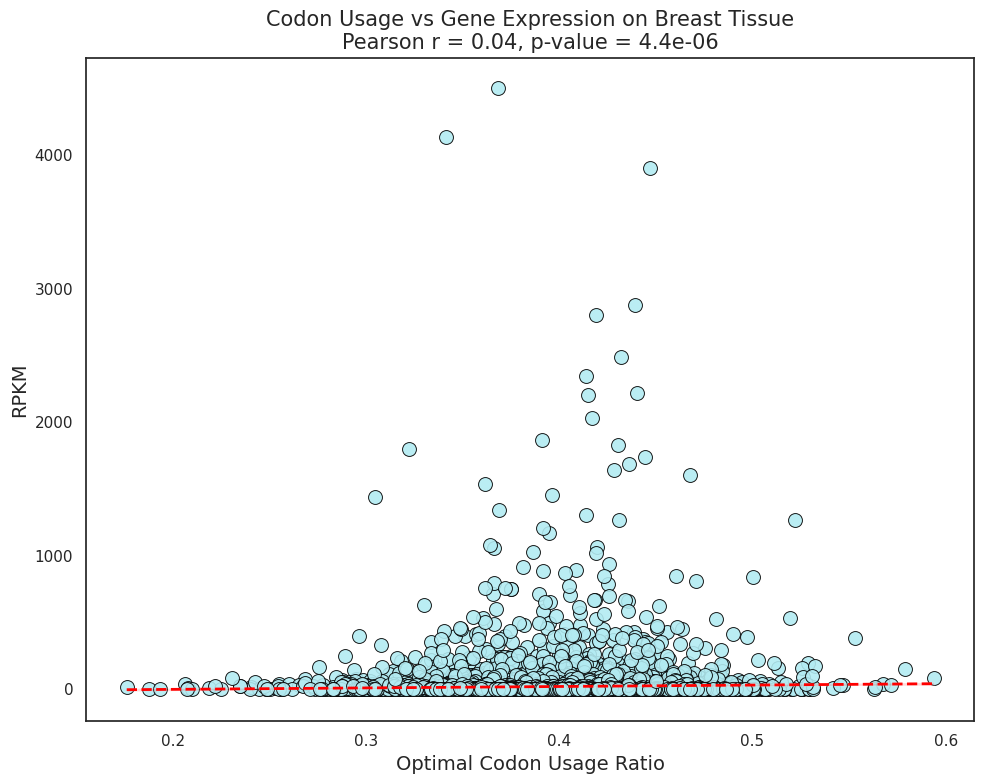

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Merge data
merged_df = pd.merge(rpkm, df_results, left_on='Gene_Symbol', right_on='Gene', how='left')
unmatched = merged_df[merged_df['Optimal_Codon_Usage_Ratio'].isna()]
if unmatched.empty:
    print("All genes in the RPKM dataset have matching codon usage data.")
else:
    print("The following genes from RPKM do NOT have matching codon usage data:")
    print(unmatched['Gene_Symbol'])

# Filter valid data
valid_df = merged_df.dropna(subset=['Optimal_Codon_Usage_Ratio'])
corr, p_val = pearsonr(valid_df['Optimal_Codon_Usage_Ratio'], valid_df['RPKM'])
print("Pearson correlation coefficient:", corr)
print("P-value:", p_val)

# Plotting
sns.set_style("white")
sns.set_context("notebook")

plt.figure(figsize=(10, 8))

# Scatter plot
sns.scatterplot(
    data=valid_df,
    x='Optimal_Codon_Usage_Ratio',
    y='RPKM',
    s=100,
    edgecolor='black',
    linewidth=0.7,
    alpha=0.9,
    color='#B3EBF2'
)

# Regression line (no scatter points)
sns.regplot(
    data=valid_df,
    x='Optimal_Codon_Usage_Ratio',
    y='RPKM',
    scatter=False,
    color='red',  # Line color
    line_kws={'linewidth': 2, 'linestyle': '--'}
)

plt.title(f'Codon Usage vs Gene Expression on Breast Tissue\nPearson r = {corr:.2f}, p-value = {p_val:.2g}', fontsize=15)
plt.xlabel('Optimal Codon Usage Ratio', fontsize=14)
plt.ylabel('RPKM', fontsize=14)

plt.tight_layout()
plt.show()


### Interpretation of Results

The **Pearson correlation coefficient** between optimal codon usage ratio and gene expression (RPKM) is:

- **r = 0.037**
- **p-value = 4.36 × 10⁻⁶**

This reflects a **very weak positive correlation** between codon optimization and expression level across genes in human breast tissue. Although the p-value is extremely low, indicating statistical significance (rejecting null of non-linearity), this result should be interpreted with caution.

#### Important Considerations:

- **Effect Size vs. Significance:**  
  The correlation is statistically significant but **biologically weak**. A low p-value can result from the **large sample size** (i.e. thousands of genes), even when the actual association is minimal.
  
- **No Inference to a Larger Population:**  
  Since we are analyzing the **entire set of protein-coding genes**, this is **not a sample**, and traditional inferential statistics (like p-values) are less meaningful. We're not trying to generalize to a larger population — we're describing the dataset as a whole.

- **Biological Interpretation:**  
  Codon optimization may have some influence on gene expression, but it is likely a **minor factor** compared to other layers of gene regulation (e.g., promoter activity, chromatin state, mRNA decay).

#### Future Directions:

- Stratify the analysis by gene categories (e.g., housekeeping vs. tissue-specific genes)
- Compare across tissues or species to explore context-specific codon bias
